In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.pipeline import EntityRuler
import warnings
warnings.filterwarnings('ignore')

# Read in SalesItems_3.csv for comparison, take same number samples

In [2]:
pd.options.display.float_format = "{:.4f}".format
col_dtypes = {'global_id': 'string',
              'inventory_id':'string',
              'sale_id':'string',
              'batch_id':'string',
              'description':'string',
              'qty':'float16',
              'uom':'category',
              'unit_price':'float16',
              'price_total':'float16',
              'name':'string'
             }

date_cols = ['created_at',
             'updated_at',
             'sold_at'
            ]

product_sales_WA = pd.read_csv('SaleItems_3.csv', sep = '\t', encoding = 'utf-16', nrows = 110000)
product_sales_WA.rename(columns = {'global_id':'sale_prod_id'}, inplace=True)
product_sales_WA['description'] = np.where(product_sales_WA['description'].isna(),product_sales_WA['name'],product_sales_WA['description'])

product_sales_WA = product_sales_WA.loc[product_sales_WA.price_total > 0]
product_sales_WA = product_sales_WA[product_sales_WA.price_total < product_sales_WA.price_total.quantile(.95)] #takes out about 5%


# To mirror the data set use by that of Charles Rice @ UFO Software, Keegan Skeate @ Cannalytics
num_products = product_sales_WA.shape[0]
product_sales_WA.head()

,sale_prod_id,created_at,updated_at,mme_id,user_id,inventory_id,external_id,sale_id,batch_id,use_by_date,description,sold_at,qty,uom,unit_price,price_total,name
0,WAR428942.SI4GV61K,2021-01-23 11:30:05,2021-01-23 11:30:05,WAWA1.MMAB,WAWA1.US8C,WAR428942.INT5BV5,sales_history-3765662,WAR428942.SA38MM26,WAR428942.BAMONMZ,2022-01-18,Flower 3.5g,2021-01-22 16:00:00,1.0000,ea,22.2900,22.2900,Flower 3.5g
1,WAR428942.SI4GV61L,2021-01-23 11:30:05,2021-01-23 11:30:05,WAWA1.MMAB,WAWA1.US8C,WAR428942.INQY6GZ,sales_history-3765662,WAR428942.SA38MM26,WAR428942.BALGTEP,1900-01-01,Edible (Solid) - 100g,2021-01-22 16:00:00,1.0000,ea,20.5400,20.5400,BON BOMBS MINT 100mg
2,WAT430644.SI4GV61M,2021-01-23 11:30:06,2021-01-23 11:30:06,WAWA1.MM2AT,WAWA1.US3Q4,WAT430644.INSWLC5,D7525CA0-5DF2-11EB-96DC-1D003DFB0DDF,WAT430644.SA38MM27,WAT430644.BAMJPB9,1900-01-01,Usable marijuana (1g),2021-01-22 16:00:00,1.0000,ea,3.4000,3.4000,Wedding Cake Joint-1g (IH)
3,WAT430644.SI4GV61N,2021-01-23 11:30:06,2021-01-23 11:30:06,WAWA1.MM2AT,WAWA1.US3Q4,WAT430644.INSWLC5,D7525CA0-5DF2-11EB-96DC-1D003DFB0DDF,WAT430644.SA38MM27,WAT430644.BAMJPB9,1900-01-01,Usable marijuana (1g),2021-01-22 16:00:00,1.0000,ea,3.4000,3.4000,Wedding Cake Joint-1g (IH)
4,WAT430644.SI4GV61O,2021-01-23 11:30:06,2021-01-23 11:30:06,WAWA1.MM2AT,WAWA1.US3Q4,WAT430644.INT4QW1,D7525CA0-5DF2-11EB-96DC-1D003DFB0DDF,WAT430644.SA38MM27,WAT430644.BAMO7R2,1900-01-01,Terpee Slurpee Platinum Line 3.5g [ Terpee Sl...,2021-01-22 16:00:00,1.0000,ea,19.9900,19.9900,Terpee Slurpee Platinum Line 3.5g [ Terpee Sl...


In [3]:
# natural language processing English pipeline
nlp = spacy.blank('en') 

In [4]:
# create an entity ruler to label units preceded by a number as a quantity
ruler = nlp.add_pipe("entity_ruler")
weights_pattern = [
    {"LIKE_NUM": True},
    {"LOWER": {"IN": ["g", "kg", "grams", 'gram', "mg", "kilograms", "kilogram", "milligrams", "milligram", 'ounce', 'ounces', 'oz', 'lb']}}
]
patterns = [{"label": "QUANTITY", "pattern": weights_pattern}]
ruler.add_patterns(patterns)

In [5]:
# Create a random sample for development.
sample_size = [10, 50, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 50000, 100000]
idr = []
for i,s in enumerate(sample_size):
    sample = product_sales_WA.sample(s, random_state=i)
    identified = 0
    for index, values in sample.iterrows():
        try:
            doc = nlp(values['name'])
            for entity in doc.ents:
                if entity.label_ == 'QUANTITY':
                    #print('Text:', entity.text)
                    identified += 1
                    break #since QUANTITY ruler catches multiple quantities in certain products
        except ValueError:
            pass

    identification_rate = identified / s
    idr.append(identification_rate * 100)
    print('Identified: %.03f%%' % (identification_rate * 100))
    print('Sample Size: %d' % (s))
# Look at named entities in product names.
#for index, values in sample.iterrows():
#    try:
#        doc = nlp(values['name'])
#        #displacy.render(doc, style='ent')
#    except ValueError:
#        pass


Identified: 70.000%
Sample Size: 10
Identified: 56.000%
Sample Size: 50
Identified: 69.000%
Sample Size: 100
Identified: 63.600%
Sample Size: 250
Identified: 68.800%
Sample Size: 500
Identified: 65.067%
Sample Size: 750
Identified: 69.500%
Sample Size: 1000
Identified: 67.880%
Sample Size: 2500
Identified: 68.060%
Sample Size: 5000
Identified: 66.827%
Sample Size: 7500
Identified: 67.610%
Sample Size: 10000
Identified: 67.032%
Sample Size: 50000
Identified: 67.118%
Sample Size: 100000


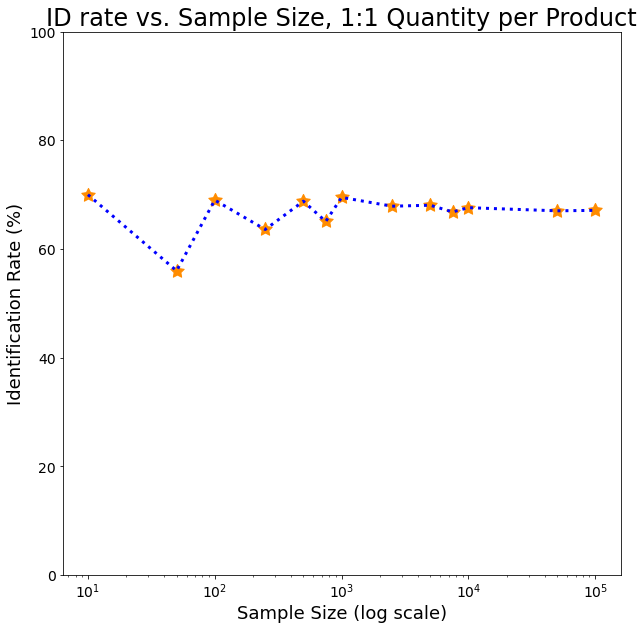

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(sample_size,idr,marker=(5,1),s=200,color='darkorange')
plt.semilogx(sample_size,idr,linestyle='dotted',linewidth=3,color='blue')
plt.xlabel('Sample Size (log scale)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Identification Rate (%)', fontsize=18)
plt.ylim([0, 100])
plt.title('ID rate vs. Sample Size, 1:1 Quantity per Product',fontsize=24)
plt.savefig('id_rate.pdf',bbox_inches='tight')
plt.show()

# Out 

In [7]:
identified = 0
for index, values in sample.iterrows():
    try:
        doc = nlp(values['name'])
        for entity in doc.ents:
            if entity.label_ == 'QUANTITY':
                #print('Text:', entity.text)
                identified += 1
    except ValueError:
        pass
identification_rate = identified / sample_size
print('Identified: %.03f%%' % (identification_rate * 100))
print('Sample Size: %d' % (sample_size))

TypeError: unsupported operand type(s) for /: 'int' and 'list'